In [4]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
%load_ext tensorboard

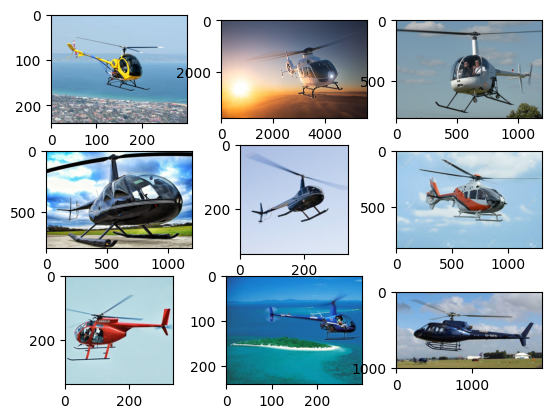

In [5]:
#Code to visualize the images


# plot Helicopter images from the Helicopter vs Airplane dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'Dataset/Train/Helicopter/'
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + '0000000' + str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()


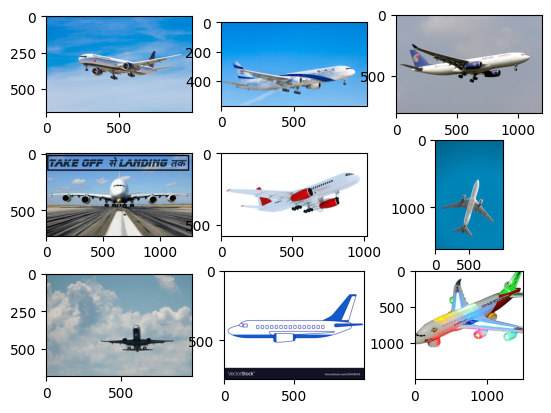

In [8]:
#Code to visualize the images


## plot Airplane images from the Helicopter vs Airplane dataset

from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'Dataset/Train/Airplane/'
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + '0000000' + str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()


VGG1

In [9]:
# baseline model for the Helicopter vs Airplane dataset

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import time
import datetime
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


vgg1=[]

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	pyplot.savefig('plot_block1.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# setup tensorboard
	log_dir = "logs/fit/vgg1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

	tensorboard_callback = keras.callbacks.TensorBoard(log_dir, histogram_freq=1, update_freq='batch')
	# fit model

	start_time = time.time()
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it),callbacks=[tensorboard_callback], epochs=10, verbose=0)
	end_time = time.time()
	training_time = end_time - start_time
	_, test_labels = next(test_it)
	prediction = model.predict_generator(test_it, steps=len(test_it), verbose=0)
	bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
	loss = bce(test_labels.reshape(-1,1), prediction.reshape(-1,1)).numpy()


	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	_, acc2 = model.evaluate(train_it, steps=len(train_it), verbose=0)
	print(' Test Accuracy > %.3f' % (acc * 100.0))
	print('Training Accuracy> %.3f' % (acc2 * 100.0))
	vgg1.append(training_time)
	vgg1.append(loss)
	vgg1.append(acc)
	vgg1.append(acc2)
	vgg1.append(model.count_params())
	# learning curves
	summarize_diagnostics(history)
	return model

# entry point, run the test harness
model=run_test_harness()


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


KeyboardInterrupt: 

In [6]:
import numpy as np
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
test_images, test_labels = next(test_it)
model.predict(test_images)

predicted_labels = np.romodel.predict(test_images))
predicted_labels.flatten()

# Clear out prior logging data.

from datetime import datetime
import io

logdir = "logs/plots/vgg1" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
class_names = ['Airplane', 'Helicopter']

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[int(predicted_labels[i].flatten()[0])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("Training data", plot_to_image(figure), step=0)



Found 40 images belonging to 2 classes.
2/2 [==============================] - 0s 30ms/step


In [7]:
%tensorboard --logdir logs

In [8]:
model.save('vgg1')

INFO:tensorflow:Assets written to: vgg1\assets


INFO:tensorflow:Assets written to: vgg1\assets


VGG3

In [10]:
vgg3=[]
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	pyplot.savefig('plot_block3.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	log_dir = "logs/fit/vgg3" + datetime.now().strftime("%Y%m%d-%H%M%S")

	tensorboard_callback = keras.callbacks.TensorBoard(log_dir, histogram_freq=1, update_freq='batch')
	# fit model
	start_time = time.time()
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it),callbacks=[tensorboard_callback], epochs=20, verbose=0)
	end_time = time.time()
	training_time = end_time - start_time
	_, test_labels = next(test_it)
	prediction = model.predict_generator(test_it, steps=len(test_it), verbose=0)
	bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
	loss = bce(test_labels.reshape(-1,1), prediction.reshape(-1,1)).numpy()
	
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	_, acc2 = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
	print('Test > %.3f' % (acc * 100.0))
	print('Training > %.3f' % (acc2 * 100.0))
	vgg3.append(training_time)
	vgg3.append(loss)
	vgg3.append(acc)
	vgg3.append(acc2)
	vgg3.append(model.count_params())
	# learning curves
	summarize_diagnostics(history)
	return model

# entry point, run the test harness
model=run_test_harness()

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Test > 75.000
Training > 95.000


In [12]:
import numpy as np
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
test_images, test_labels = next(test_it)
model.predict(test_images)

predicted_labels = np.round(model.predict(test_images))
predicted_labels.flatten()

# Clear out prior logging data.

from datetime import datetime
import io

logdir = "logs/plots/vgg3" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
class_names = ['Airplane', 'Helicopter']

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[int(predicted_labels[i].flatten()[0])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("Predictions VGG 3", plot_to_image(figure), step=0)

%tensorboard --logdir logs/plots

Found 40 images belonging to 2 classes.
2/2 [==============================] - 0s 66ms/step


In [13]:
model.save('vgg3')


INFO:tensorflow:Assets written to: vgg3\assets


INFO:tensorflow:Assets written to: vgg3\assets


VGG 3 with data augmentation

In [15]:
vgg3_aug=[]
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
 # plot loss
 pyplot.subplot(211)
 pyplot.title('Cross Entropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 filename = sys.argv[0].split('/')[-1]
 pyplot.savefig('plot4.png')
 pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
 # define model
 model = define_model()
 # create data generators
 train_datagen = ImageDataGenerator(rescale=1.0/255.0,
 width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
 test_datagen = ImageDataGenerator(rescale=1.0/255.0)
 # prepare iterators
 train_it = train_datagen.flow_from_directory('Dataset/Train/',
 class_mode='binary', batch_size=64, target_size=(200, 200))
 test_it = test_datagen.flow_from_directory('Dataset/Test/',
 class_mode='binary', batch_size=64, target_size=(200, 200))
 log_dir = "logs/fit/vgg3aug" + datetime.now().strftime("%Y%m%d-%H%M%S")
 tensorboard_callback = keras.callbacks.TensorBoard(log_dir, histogram_freq=1, update_freq='batch')

 # fit model
 start_time = time.time()
 history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), callbacks = [tensorboard_callback], epochs=50, verbose=0)
 end_time=time.time()
 training_time = end_time - start_time
 _, test_labels = next(test_it)
 prediction = model.predict_generator(test_it, steps=len(test_it), verbose=0)
 bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
 loss = bce(test_labels.reshape(-1,1), prediction.reshape(-1,1)).numpy()
 
 # evaluate model
 _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
 _, acc2 = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
 vgg3_aug.append(training_time)
 vgg3_aug.append(loss)
 vgg3_aug.append(acc)
 vgg3_aug.append(acc2)
 vgg3_aug.append(model.count_params())
 print(' Test > %.3f' % (acc * 100.0))
 print(' Training> %.3f' % (acc2 * 100.0))
 # learning curves
 summarize_diagnostics(history)
 return model
 
# entry point, run the test harness
model=run_test_harness()

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
 Test > 80.000
 Training> 92.500


In [17]:
import numpy as np
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
test_images, test_labels = next(test_it)
model.predict(test_images)

predicted_labels = np.round(model.predict(test_images))
predicted_labels.flatten()

# Clear out prior logging data.

from datetime import datetime
import io

logdir = "logs/plots/vgg3aug" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
class_names = ['Airplane', 'Helicopter']

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[int(predicted_labels[i].flatten()[0])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("Predictions VGG3 with data augmentation", plot_to_image(figure), step=0)

%tensorboard --logdir logs/plots

Found 40 images belonging to 2 classes.
2/2 [==============================] - 0s 72ms/step


In [18]:
model.save('vgg3_aug')

INFO:tensorflow:Assets written to: vgg3_aug\assets


INFO:tensorflow:Assets written to: vgg3_aug\assets


VGG 16 using Transfer Learning

In [22]:
# vgg16 model used for transfer learning 
from keras.applications.vgg16 import VGG16
from keras.models import Model

transfer=[]
# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig('transfer_learning_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	log_dir = "logs/fit/vgg16" + datetime.now().strftime("%Y%m%d-%H%M%S")
	tensorboard_callback = keras.callbacks.TensorBoard(log_dir, histogram_freq=1, update_freq='batch')
	# fit model
	start_time=time.time()
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), callbacks=[tensorboard_callback], epochs=10, verbose=1)
	end_time=time.time()
	training_time=end_time-start_time
	_, test_labels = next(test_it)
	prediction = model.predict_generator(test_it, steps=len(test_it), verbose=0)
	bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
	loss = bce(test_labels.reshape(-1,1), prediction.reshape(-1,1)).numpy()
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	_, acc2 = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
	transfer.append(training_time)
	transfer.append(loss)
	transfer.append(acc)
	transfer.append(acc)
	transfer.append(model.count_params())
	print(' Training > %.3f' % (acc * 100.0))
	print('Test > %.3f' % (acc2 * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return model
# entry point, run the test harness
model=run_test_harness()

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 39s 16s/step - loss: 14.6383 - accuracy: 0.4938 - val_loss: 4.9986 - val_accuracy: 0.8000
Epoch 2/10
3/3 [==============================] - 52s 15s/step - loss: 2.8246 - accuracy: 0.9187 - val_loss: 1.6942 - val_accuracy: 0.9000
Epoch 3/10
3/3 [==============================] - 43s 15s/step - loss: 0.2368 - accuracy: 0.9875 - val_loss: 1.5207 - val_accuracy: 0.9000
Epoch 4/10
3/3 [==============================] - 44s 15s/step - loss: 0.0712 - accuracy: 0.9812 - val_loss: 1.5999 - val_accuracy: 0.9250
Epoch 5/10
3/3 [==============================] - 44s 15s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.6896 - val_accuracy: 0.9250
Epoch 6/10
3/3 [==============================] - 47s 16s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.7719 - val_accuracy: 0.9250
Epoch 7/10
3/3 [==============================] - 47s 20s/step - loss: 3.8405e-05 - 

In [20]:
model = tf.keras.models.load_model('vgg16_transfer')


In [24]:
import numpy as np
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
test_images, test_labels = next(test_it)
model.predict(test_images)

predicted_labels = np.round(model.predict(test_images))
predicted_labels.flatten()

# Clear out prior logging data.

from datetime import datetime
import io

logdir = "logs/plots/vgg16" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
class_names = ['Airplane', 'Helicopter']

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[int(predicted_labels[i].flatten()[0])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("VGG 16 Predictions", plot_to_image(figure), step=0)

%tensorboard --logdir logs/plots

Found 40 images belonging to 2 classes.


2/2 [==============================] - 7s 1s/step


In [23]:
model.save('vgg16_transfer')

INFO:tensorflow:Assets written to: vgg16_transfer\assets


INFO:tensorflow:Assets written to: vgg16_transfer\assets


MLP

In [18]:
#MLP model with comparable number of parameters to VGG16

mlp=[]
def define_model():
    # define model
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(96, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9,clipnorm=1.)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig('transfer_learning_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	log_dir = "logs/fit/mlp" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
	tensorboard_callback = keras.callbacks.TensorBoard(log_dir, histogram_freq=1, update_freq='batch')
	# fit model
	start_time=time.time()
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it),callbacks=[tensorboard_callback], epochs=10, verbose=1)
	end_time=time.time()
	training_time=end_time-start_time
	_, test_labels = next(test_it)
	prediction = model.predict_generator(test_it, steps=len(test_it), verbose=0)
	bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
	loss = bce(test_labels.reshape(-1,1), prediction.reshape(-1,1)).numpy()
	# evaluate model
	_, acc = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
	_, acc2 = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)

	# //find loss for test predictions and store it
	_, test_labels = next(test_it)
	prediction = model.predict_generator(test_it, steps=len(test_it), verbose=0)
	bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
	print(bce(test_labels.reshape(-1,1), prediction.reshape(-1,1)).numpy())


	mlp.append(training_time)
	mlp.append(loss)
	mlp.append(acc)
	mlp.append(acc2)
	mlp.append(model.count_params())
	print(' Training > %.3f' % (acc * 100.0))
	print('Test > %.3f' % (acc2 * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return model
# entry point, run the test harness
model=run_test_harness()

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 5s 2s/step - loss: 28.8509 - accuracy: 0.5312 - val_loss: 16.4182 - val_accuracy: 0.5500
Epoch 2/10
3/3 [==============================] - 7s 3s/step - loss: 21.2046 - accuracy: 0.5500 - val_loss: 14.0626 - val_accuracy: 0.5750
Epoch 3/10
3/3 [==============================] - 8s 3s/step - loss: 13.4468 - accuracy: 0.6000 - val_loss: 18.9864 - val_accuracy: 0.5500
Epoch 4/10
3/3 [==============================] - 7s 3s/step - loss: 10.3969 - accuracy: 0.6938 - val_loss: 13.1345 - val_accuracy: 0.6000
Epoch 5/10
3/3 [==============================] - 9s 4s/step - loss: 7.1362 - accuracy: 0.7125 - val_loss: 13.1150 - val_accuracy: 0.6000
Epoch 6/10
3/3 [==============================] - 8s 3s/step - loss: 3.0892 - accuracy: 0.8125 - val_loss: 10.9934 - val_accuracy: 0.6500
Epoch 7/10
3/3 [==============================] - 8s 4s/step - loss: 1.5107 - accuracy:

In [19]:
import numpy as np
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
test_images, test_labels = next(test_it)
model.predict(test_images)

predicted_labels = np.round(model.predict(test_images))
predicted_labels.flatten()

# Clear out prior logging data.

from datetime import datetime
import io

logdir = "logs/plots/mlp" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
class_names = ['Airplane', 'Helicopter']

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[int(predicted_labels[i].flatten()[0])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("MLP Predictions_1", plot_to_image(figure), step=0)

%tensorboard --logdir logs/plots

Found 40 images belonging to 2 classes.
2/2 [==============================] - 0s 9ms/step


In [33]:
model.save('mlp')

INFO:tensorflow:Assets written to: mlp\assets


INFO:tensorflow:Assets written to: mlp\assets


In [35]:
import pandas as pd

#create table for models VGG1, VGG3, VGG3 with data augmentation, VGG16 & MLP with model names as index and training time, loss, test accuracy, training accuracy and number of parameters as columns

df=pd.DataFrame({'VGG1':vgg1,'VGG3':vgg3,'VGG16':transfer,'VGG3 with data augmetation':vgg3_aug,'MLP':mlp},index=['Training time','Loss','Training accuracy','Test accuracy','Number of parameters'])
df

#df transpose

df=df.T
#replace loss with sum of loss elements


df

,Training time,Loss,Training accuracy,Test accuracy,Number of parameters
VGG1,166.648139,0.690304,0.60000,0.775,40961153.0
VGG3,121.477600,0.662570,0.75000,0.950,10333505.0
VGG16,316.707141,0.547975,0.90000,0.900,17926209.0
VGG3 with data augmetation,344.690094,0.635720,0.80000,0.925,10333505.0
MLP,41.573251,0.668669,0.98125,0.675,19283233.0


In [ ]:
import tensorflow as tf
from tensorflow import 

In [64]:
model = tf.keras.models.load_model('vgg16_transfer')

In [77]:
datagen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=True)
test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
test_images, test_labels = next(test_it)


Found 40 images belonging to 2 classes.


2/2 [==============================] - 4s 853ms/step
(array([ 4,  9, 10, 21, 23, 31], dtype=int64), array([0, 0, 0, 0, 0, 0], dtype=int64))
21


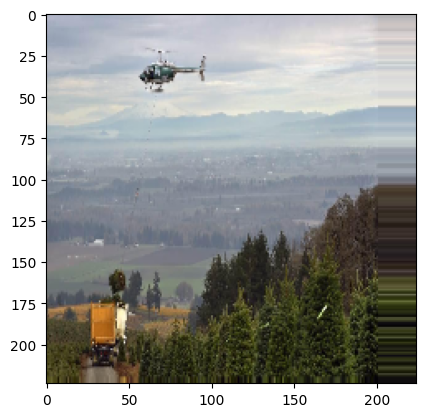

In [90]:
from PIL import Image
preds = model.predict(test_images)
import numpy as np

for val in (np.where((preds>0.49)& (preds<0.51))):
    print(val)
    test_images[val]
    plt.imshow(test_images[val], cmap=plt.cm.binary)
